In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cptsolver.fields import *
from cptsolver.utils import *
from cptsolver.plot import *
from cptsolver.integrators import *
from cptsolver.solver import *
from cptsolver.analyzer import *
from cptsolver.young import *

import pprint

from matplotlib import pyplot as plt

from datetime import datetime

We begin by grabbing the Tsyganenko model parameters from the dataset developed by Qin et al. (2007).

In [3]:
year = 2008
month = 3
day = 26
hour = 11
minute = 19

time = datetime(year, month, day, hour, minute)
parmod, ut, v_sw = get_txx_params('data/qindenton_03-26-2008', 'data/omni_03-26-2008', time)
b_field = t04(parmod, ut, v_sw)

Load IGRF coefficients ...


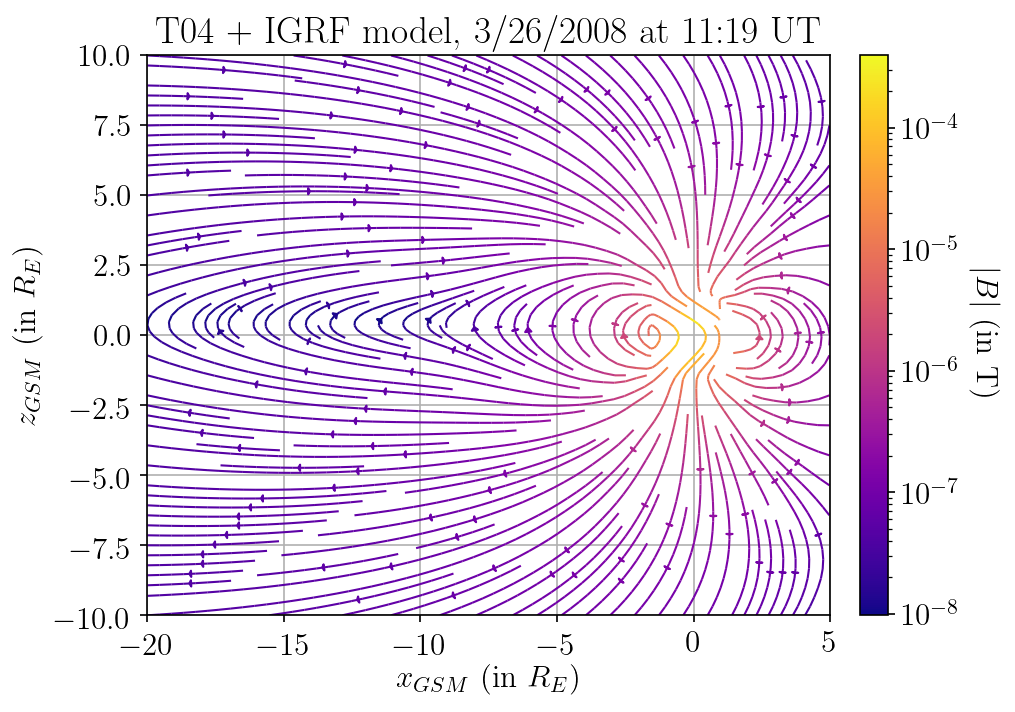

In [4]:
format_plots()
plot_field(b_field, np.array([1., 0., 0.]), np.array([0., 0., 1.]), [-20, 5], [-10, 10], size=(7, 5), labels=('$x_{GSM}$ (in $R_E$)', '$z_{GSM}$ (in $R_E$)', '$|B|$ (in T)'), title=f'T04 + IGRF model, {month}/{day}/{year} at {hour}:{minute} UT')

We next trace a field line at the specificed $L$ value along the midnight plane. After determining $\mathbf{B}$ along the field line, we calculate the $B_{\text{mirror}}$ and $B_0$.

In [5]:
L = 9.52

rr = field_line(b_field, np.array([-L * Re, 0., 0.]))
L_actual = np.amax(np.linalg.norm(rr, axis=1)) / Re
print(f'The actual L-shell is {L_actual:.2f}.')

bv, bm, brm = b_along_path(b_field, rr)
cs_ind = bm.argmin()

b_mirror_south = bm[np.abs(np.linalg.norm(rr[0:cs_ind], axis=1) - (Re + 100e3)).argmin()]
b_mirror_north = bm[np.abs(np.linalg.norm(rr[cs_ind:], axis=1) - (Re + 100e3)).argmin() + cs_ind]

b0 = bm[cs_ind]
b_mirror = min(b_mirror_north, b_mirror_south)

eq_loss_cone_ang = np.arcsin(np.sqrt(bm[cs_ind] / b_mirror))
print(f'The equatorial loss cone angle is {np.degrees(eq_loss_cone_ang):.3f} degrees.')

The actual L-shell is 10.00.
The equatorial loss cone angle is 0.745 degrees.


We can compare the normalized bounce time between the Tsyganenko model and the usual expression valid in a dipole field.

In [6]:
T_alpha = normalized_bounce_time(b_field, L)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


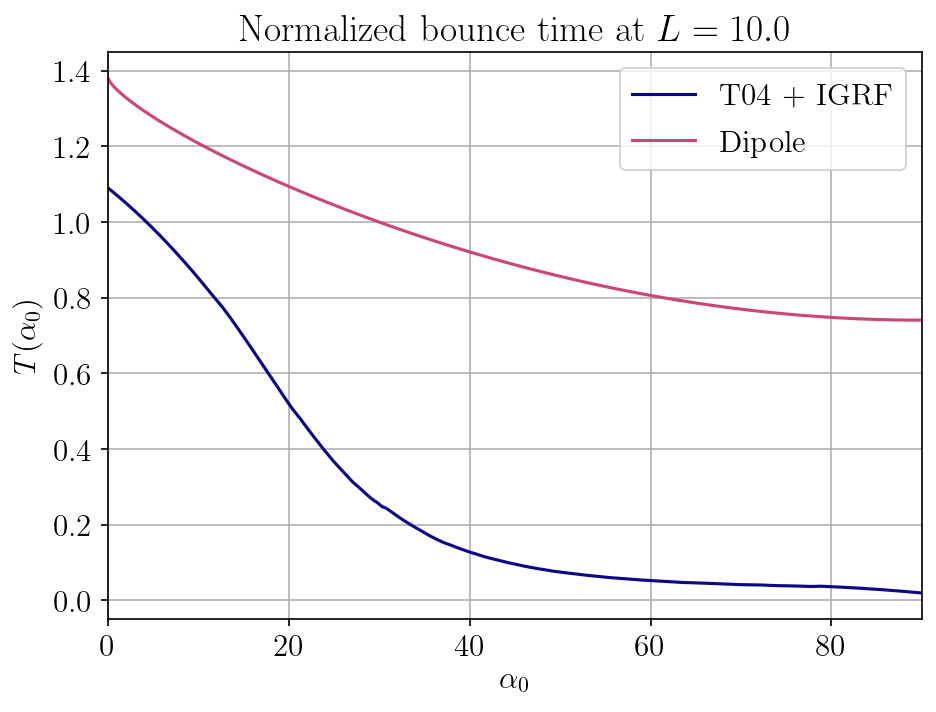

In [7]:
plt.figure(figsize=(7, 5))

alpha_eqs = np.radians(np.linspace(0, 90, 500))
plt.plot(np.degrees(alpha_eqs), T_alpha(alpha_eqs), label='T04 + IGRF')
plt.plot(np.degrees(alpha_eqs), T_dipole(alpha_eqs), label='Dipole', c='C7')

plt.xlim([0, 90])
plt.xlabel(r'$\alpha_0$')
plt.ylabel(r'$T(\alpha_0)$')
plt.title(f'Normalized bounce time at $L = {L_actual:.1f}$')

plt.legend()
plt.grid()
plt.show()

By guessing at the current sheet thickness $L_{cs}$, we generate the Harris model corresponding to the above Tsyganenko model.

In [8]:
z1, z2 = zetas_general(b_field, L)

# sigma = np.sqrt((z1 - 3) / 2) # From z1
sigma = z2 # From z2
# sigma = 0.93 # Manually

L_cs = flc(b_field, rr[cs_ind]) / sigma

b0x, sigma, L_cs = harris_params_from_txx(b_field, L, L_cs)
b_field_h = harris_cs_model(b0x, sigma, L_cs)

We can then examine the properties of this model and compare them to the Tsyganenko.

In [9]:
zsT = (rr[:, 2] - rr[cs_ind, 2]) / Re
flcT = np.zeros(len(bm))

for i in range(len(flcT)):
    flcT[i] = flc(b_field, rr[i], eps=10) / Re
    
N = 200
zs = np.linspace(-2, 2, N)

bm0 = np.zeros(N)
bm1 = np.zeros(N)

flc0 = np.zeros(N)
flc1 = np.zeros(N)

for i in range(N):
    bm0[i] = np.linalg.norm(b_field_h(np.array([0., 0., zs[i] * Re])))
    flc0[i] = flc(b_field_h, np.array([0., 0., zs[i] * Re]), eps=10) / Re
    
bh_v = np.zeros((300, 3))
zs_h = np.linspace(-2, 2, 300)

for i in range(300):
    bh_v[i] = b_field_h(np.array([0., 0., zs_h[i] * Re]))

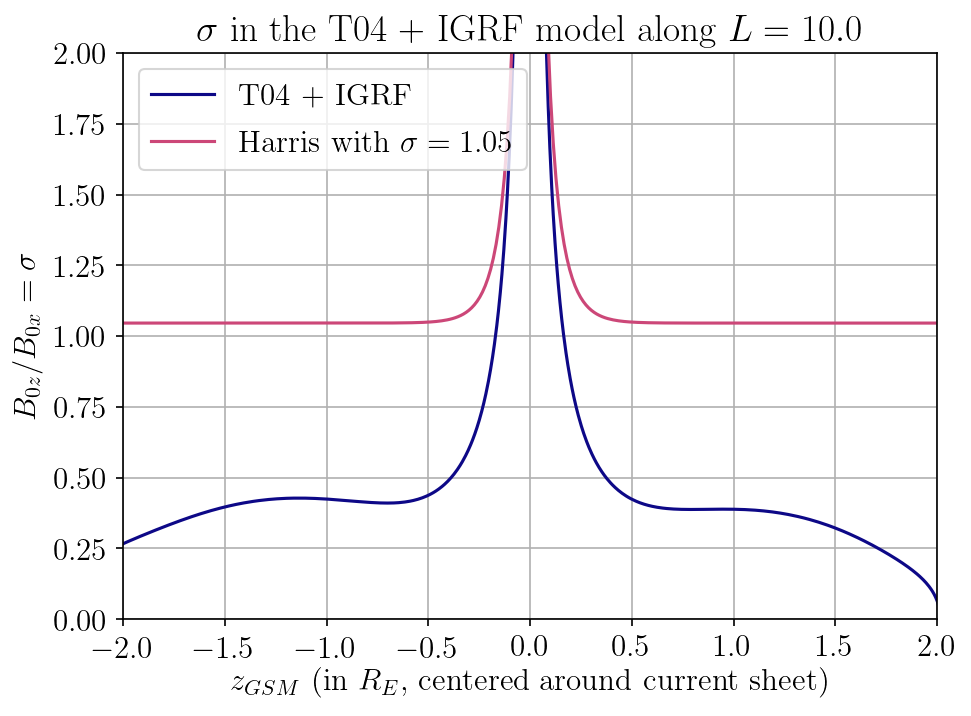

In [10]:
pad = 480
plt.figure(figsize=(7, 5))

plt.plot((rr[:, 2][pad:-pad] - rr[cs_ind, 2]) / Re, np.abs(bv[:, 2][pad:-pad] / bv[:, 0][pad:-pad]), label='T04 + IGRF')
plt.plot(zs_h, np.abs(bh_v[:, 2] / bh_v[:, 0]), c='C7', label=f'Harris with $\sigma={sigma:.2f}$')

plt.xlim([-2, 2])
plt.xlabel('$z_{GSM}$ (in $R_E$, centered around current sheet)')
plt.ylim([0, 2])
plt.ylabel(r'$B_{0z}/B_{0x} = \sigma$')
plt.title(f'$\sigma$ in the T04 + IGRF model along $L = {L_actual:.1f}$')

plt.legend()
plt.grid()
plt.show()

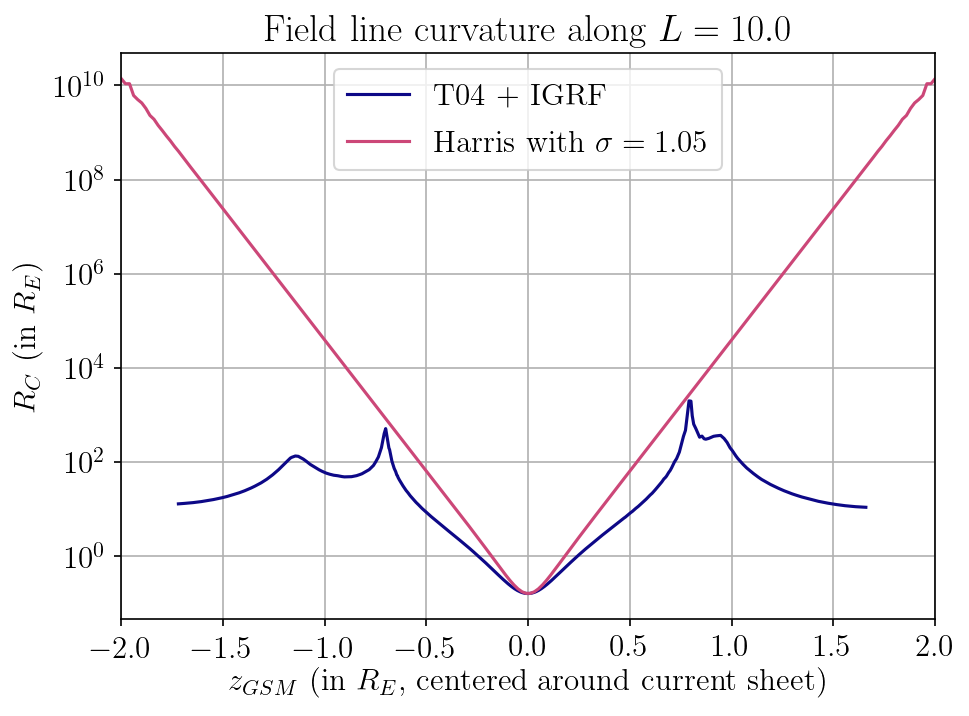

In [11]:
format_plots()
plt.figure(figsize=(7, 5))

plt.semilogy(zsT[cs_ind-200:cs_ind+200], flcT[cs_ind-200:cs_ind+200], label=r'T04 + IGRF', c='C0')    
plt.semilogy(zs, flc0, label=f'Harris with $\sigma={sigma:.2f}$', c='C7')

plt.xlim([-2, 2])
plt.xlabel('$z_{GSM}$ (in $R_E$, centered around current sheet)')
plt.ylabel('$R_C$ (in $R_E$)')
plt.title(f'Field line curvature along $L={L_actual:.1f}$')

plt.legend()
plt.grid()
plt.show()

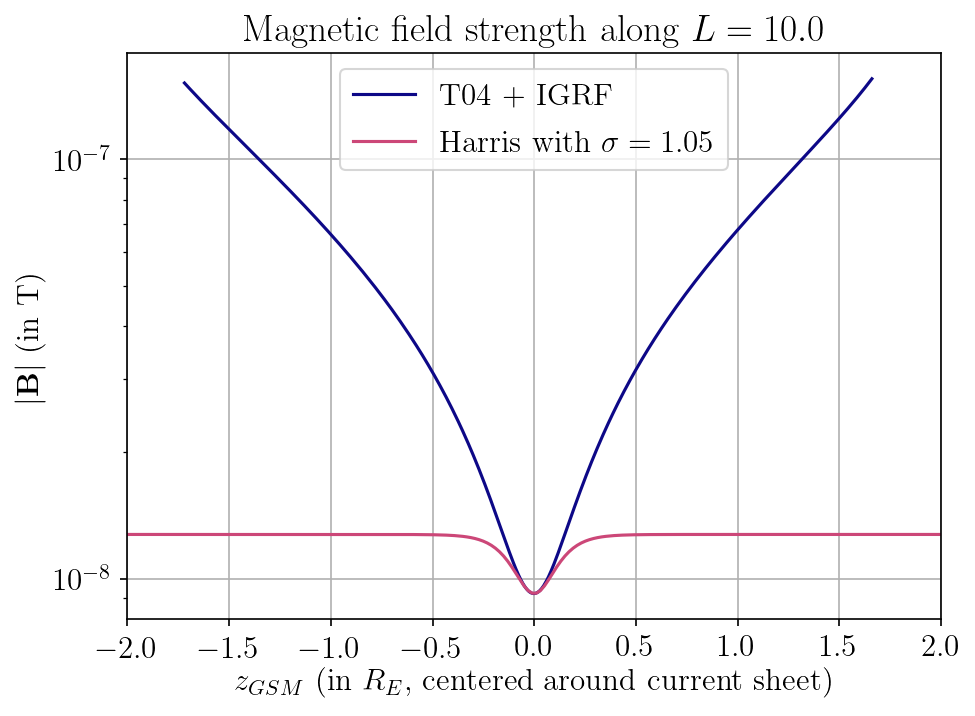

In [12]:
format_plots()
plt.figure(figsize=(7, 5))

plt.semilogy(zsT[cs_ind-200:cs_ind+200], bm[cs_ind-200:cs_ind+200], label=r'T04 + IGRF', c='C0')
plt.semilogy(zs, bm0, label=f'Harris with $\sigma={sigma:.2f}$', c='C7')

plt.xlim([-2, 2])
plt.xlabel('$z_{GSM}$ (in $R_E$, centered around current sheet)')
plt.ylabel('$|\mathbf{B}|$ (in T)')
plt.title(f'Magnetic field strength along $L={L_actual:.1f}$')

plt.legend()
plt.grid()
plt.show()

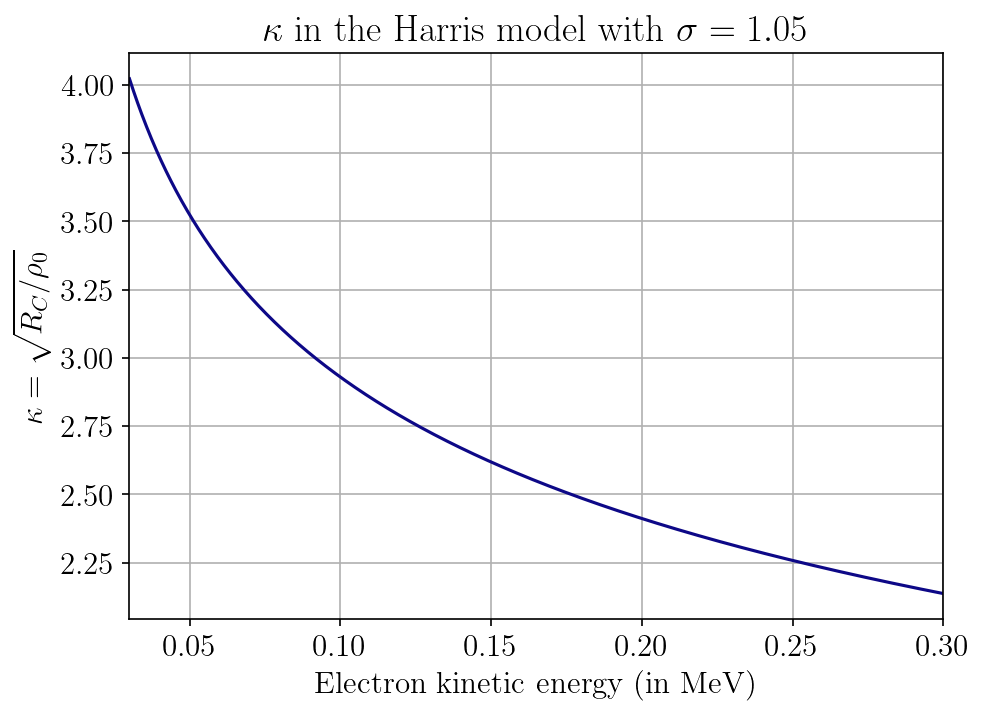

In [13]:
energies = np.linspace(30e3, 300e3, 1000)

def kappa_h(E):
    gamma = eV_to_J(E) / (sp.m_e * sp.c**2) + 1
    v = sp.c * np.sqrt(1 - 1 / gamma**2)
    return np.sqrt(np.abs(-sp.e) * sigma**2 * L_cs * b0x / (gamma * sp.m_e * v))

plt.figure(figsize=(7, 5))

plt.plot(energies * 1e-6, kappa_h(energies), c='C0')

plt.xlim([3e-2, 3e-1])
plt.xlabel('Electron kinetic energy (in MeV)')
plt.ylabel(r'$\kappa = \sqrt{R_C/ \rho_0}$')
plt.title(f'$\kappa$ in the Harris model with $\sigma = {sigma:.2f}$')

plt.grid()
plt.show()

Using the methods of Young et al. (2002) and Young et al. (2008), we may plot the bounce-averaged equatorial pitch angle diffusion coefficient $\langle D_{\alpha_0\alpha_0}\rangle$. We may then estimate the particle lifetime using $\tau = 1/\langle D_{\alpha_0\alpha_0}(\alpha_{LC})\rangle$.

Approximate lifetime of 30 keV particles: 2.42e+08 s
Approximate lifetime of 100 keV particles: 2.38e+04 s
Approximate lifetime of 200 keV particles: 9.90e+02 s
Approximate lifetime of 300 keV particles: 2.54e+02 s


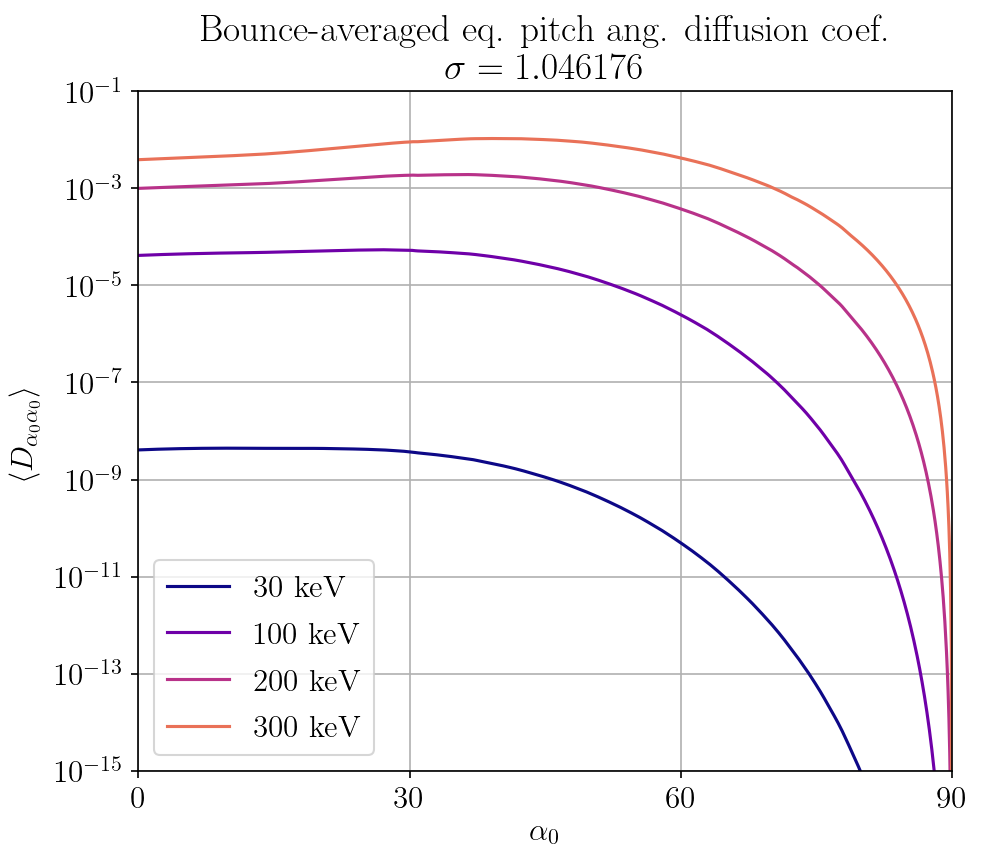

In [14]:
Es = [30, 100, 200, 300]
z1, z2 = zetas_harris(sigma)

steps = 1000
alpha_eqs = np.radians(np.linspace(1e-5, 90 - 1e-5, steps))

plt.figure(figsize=(7, 6))

for i in range(len(Es)):
    eps = epsilon_harris(Es[i] * 1e3, -sp.e, sp.m_e, b0x, sigma, L_cs)
    D_aas = D_aa(eps, z1, z2, alpha_eqs, T_alpha)
    lifetime = 1 / D_aa(eps, z1, z2, eq_loss_cone_ang, T_alpha)
    print(f'Approximate lifetime of {Es[i]} keV particles: {lifetime:.2e} s')
    plt.semilogy(np.degrees(alpha_eqs), D_aas, c=f'C{3*i}', label=f'${Es[i]}$ keV')

plt.xlim([0, 90])
plt.xticks(np.linspace(0, 90, 4))
plt.xlabel(r'$\alpha_0$')
plt.ylim([1e-15, 1e-1])
plt.ylabel(r'$\langle D_{\alpha_0\alpha_0}\rangle$')
plt.title(f'Bounce-averaged eq. pitch ang. diffusion coef.\n$\sigma = {sigma:.6f}$')

plt.legend()
plt.grid()
plt.show()

We can do the same as above with the Tsyganenko model (as opposed to the Harris model).

0.061797492741619164
3.155644481273962 1.0461757733747892
Approximate lifetime of 30 keV particles: 2.15e+09 s
0.11651955394495969
3.155644481273962 1.0461757733747892
Approximate lifetime of 100 keV particles: 6.45e+04 s
0.1719701297742759
3.155644481273962 1.0461757733747892
Approximate lifetime of 200 keV particles: 1.80e+03 s
0.21906792839013828
3.155644481273962 1.0461757733747892
Approximate lifetime of 300 keV particles: 3.78e+02 s


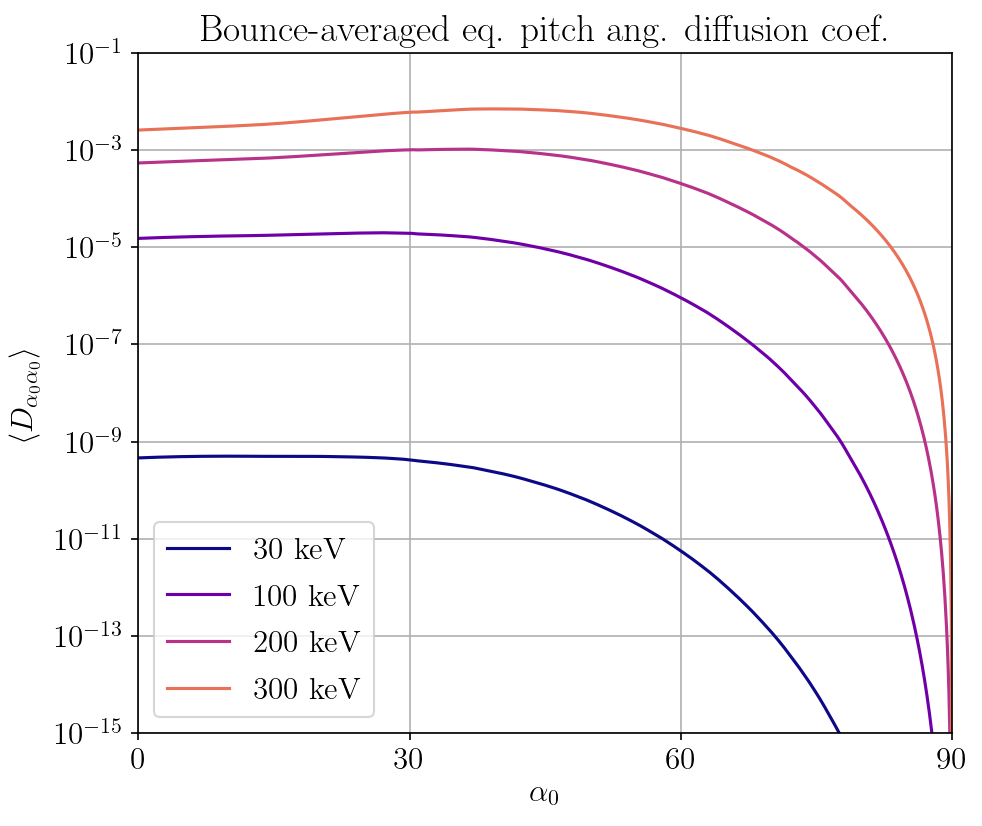

In [15]:
Es = [30, 100, 200, 300]
z1, z2 = zetas_general(b_field, L)
R_c = flc(b_field, rr[cs_ind])

steps = 1000
alpha_eqs = np.radians(np.linspace(1e-5, 90 - 1e-5, steps))

plt.figure(figsize=(7, 6))

for i in range(len(Es)):
    eps = epsilon_general(Es[i] * 1e3, -sp.e, sp.m_e, R_c, b0)
    print(eps)
    print(z1, z2)
    D_aas = D_aa(eps, z1, z2, alpha_eqs, T_alpha)
    lifetime = 1 / D_aa(eps, z1, z2, eq_loss_cone_ang, T_alpha)
    print(f'Approximate lifetime of {Es[i]} keV particles: {lifetime:.2e} s')
    plt.semilogy(np.degrees(alpha_eqs), D_aas, c=f'C{3*i}', label=f'${Es[i]}$ keV')

plt.xlim([0, 90])
plt.xticks(np.linspace(0, 90, 4))
plt.xlabel(r'$\alpha_0$')
plt.ylim([1e-15, 1e-1])
plt.ylabel(r'$\langle D_{\alpha_0\alpha_0}\rangle$')
plt.title('Bounce-averaged eq. pitch ang. diffusion coef.')

plt.legend()
plt.grid()
plt.show()

In [61]:
model = 0

In [63]:
s, r, b_spawn, pa = np.zeros(4)

if model == 0:
    # Full T04 + IGRF
    s = solver(zero_field(), b_field, higueracary)

    r = rr[cs_ind + 250]
    b_spawn = np.linalg.norm(b_field(r))
    pa = np.arcsin(np.sqrt(b_spawn / bm[cs_ind]) * np.sin(eq_loss_cone_ang))
elif model == 1:
    # Harris
    s = solver(uniform_field(1, np.array([0., 1., 0.])), b_field_h, higueracary)

    r = np.array([0., 0., -5 * Re])
    b_spawn = np.linalg.norm(b_field_h(r))
    pa = np.arcsin(np.sqrt(b_spawn / (sigma * b0x)) * np.sin(eq_loss_cone_ang))

In [48]:
# Populate

E = 300 # in keV

s.populate(
           1000,
           delta(r),
           delta(300 * E),
           delta(pa),
           np.linspace(0, 2 * np.pi, 1000),
           by_list=True
          )

100%|██████████| 1000/1000 [00:03<00:00, 310.72it/s]


In [12]:
# Solve

s.solve(1.5, 1e-4, 1e-3)

100%|██████████| 1000/1000 [07:12<00:00,  2.31it/s]


In [13]:
s.save(f'{E}kev_case_study')

Saved file 300kev_t04_case_study.hdf5 containing 95.35 megabytes of information.


In [28]:
a = analyzer(f'{E}kev_case_study')

Loaded file 300kev_t04_case_study.hdf5 containing 116.36 megabytes of information.


In [29]:
pas = a.pitch_ang()
rs = a.position()
vs = a.velocity()
ms = a.mass()
qs = a.charge()

In [31]:
crossing_ind_avg = 0

for i in range(1000):
    if model == 0:
        crossing_ind = np.linalg.norm(rs[i, 0:500], axis=1).argmax()
        crossing_ind_avg += crossing_ind
    elif model == 1:
        crossing_ind = pas[i, :].argmax()
        crossing_ind_avg += crossing_ind

crossing_ind_avg /= 1000
crossing_ind_avg = int(round(crossing_ind_avg))

In [32]:
b_min = 1e10

if model == 0:
    for i in range(1000):
        r_temp, b_temp = guiding_center(rs[i, crossing_ind_avg], vs[i, crossing_ind_avg], b_field, ms[i], qs[i])
        b_min_maybe = np.linalg.norm(b_temp)
        if b_min_maybe < b_min:
            b_min = b_min_maybe
elif model == 1:
    b_min = sigma * b0x

In [68]:
gca_points = np.zeros((1000, 2, 3))

for i in range(1000):
    if model == 0:
        r, gca_points[i, 0] = guiding_center(rs[i, 0], vs[i, 0], b_field, ms[i], qs[i])
        r, gca_points[i, 1] = guiding_center(rs[i, crossing_ind_avg * 2], vs[i, crossing_ind_avg * 2], b_field, ms[i], qs[i])
    elif model == 1:
        r, gca_points[i, 0] = guiding_center(rs[i, 0], vs[i, 0], b_field_h, ms[i], qs[i])
        r, gca_points[i, 1] = guiding_center(rs[i, crossing_ind_avg * 2], vs[i, crossing_ind_avg * 2], b_field_h, ms[i], qs[i])

In [69]:
norm_mom_bs = b_min / np.linalg.norm(gca_points, axis=2)

In [70]:
sin_pas_start = np.sin(np.arccos(np.sum(vs[:, 0] * gca_points[:, 0], axis=1) / (np.linalg.norm(vs[:, 0], axis=1) * np.linalg.norm(gca_points[:, 0], axis=1))))
sin_pas_end = np.sin(np.arccos(np.sum(vs[:, crossing_ind_avg * 2] * gca_points[:, 1], axis=1) / (np.linalg.norm(vs[:, crossing_ind_avg * 2], axis=1) * np.linalg.norm(gca_points[:, 1], axis=1))))

In [71]:
mu_initial = 0.5 * norm_mom_bs[:, 0] * sin_pas_start**2
mu_final = 0.5 * norm_mom_bs[:, 1] * sin_pas_end**2

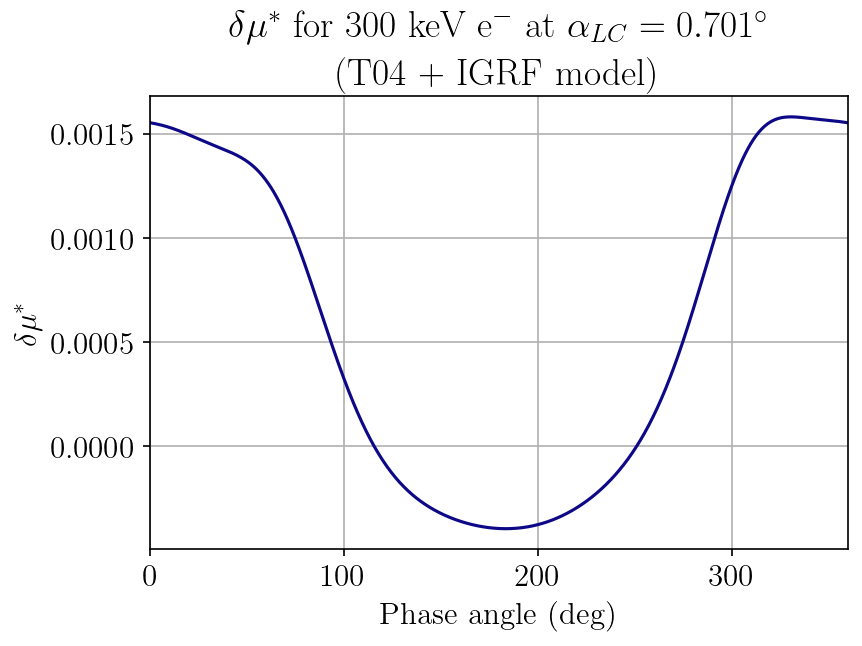

In [80]:
plt.plot(np.degrees(np.linspace(0, 2 * np.pi, 1000)), mu_final - mu_initial)
if model == 0:
    plt.title(f'$\delta\mu^*$ for ${E}$ keV e$^-$ at $\\alpha_{{LC}}={np.degrees(eq_loss_cone_ang):.3f}^\circ$\n(T04 + IGRF model)')
elif model == 1:
    plt.title(f'$\delta\mu^*$ for ${E}$ keV e$^-$ at $\\alpha_{{LC}}={np.degrees(eq_loss_cone_ang):.3f}^\circ$\n(Harris model)')
plt.ylabel(r'$\delta\mu^*$')
plt.xlabel('Phase angle (deg)')
plt.xlim([0, 360])
plt.grid()
plt.show()

In [58]:
dmu = mu_final - mu_initial
A_numerical = (np.amax(dmu) - np.amin(dmu)) / 2
print(f'The numerically found A value is: {A_numerical:.3e}')

The numerically found A value is: 9.881e-04


In [60]:
D_aa_num = A_numerical**2 / (2 * T_alpha(eq_loss_cone_ang) * np.sin(eq_loss_cone_ang)**2 * np.cos(eq_loss_cone_ang)**2)
lifetime_num = 1 / D_aa_num
print(f'The numerically found lifetime is: {lifetime_num:.3e} s')

The numerically found lifetime is: 3.299e+02 s


The Fokker-Planck diffusion equation relates the particle distribution function to the diffusion coefficient,

$$\frac{\partial f}{\partial t} = \frac{1}{\mathcal{T}_B\sin(2\alpha_0)}\frac{\partial}{\partial\alpha_0}\Big(\mathcal{T}_B\sin(2\alpha_0)D_{\alpha_0\alpha_0}\frac{\partial f}{\partial \alpha_0}\Big)$$

or

$$\frac{\partial f}{\partial t} = \frac{1}{\mathcal{T}_B\sin(2\alpha_0)}\Big[\frac{\partial}{\partial\alpha_0}\Big(\mathcal{T}_B\sin(2\alpha_0)D_{\alpha_0\alpha_0}\Big)\frac{\partial f}{\partial \alpha_0} + \Big(\mathcal{T}_B\sin(2\alpha_0)D_{\alpha_0\alpha_0}\Big)\frac{\partial^2 f}{\partial \alpha_0^2}\Big]$$

where

$$\mathcal{T}_B = \frac{4LR_E}{v}T(\alpha_0)$$

If we can approximate functions for $D_{\alpha_0\alpha_0}$ and $\mathcal{T}_B$, we should be able to find the evolution of $f$ fairly easily.

In [44]:
E = 300e3

steps = 720
alpha_eqs = np.radians(np.linspace(0, 90, steps))

gamma = E / (sp.m_e * sp.c**2) + 1.
v = sp.c * np.sqrt(1. - 1. / gamma**2)
T_B = 4 * L_actual * Re / v * T_alpha(alpha_eqs)

eps = epsilon_general(E, -sp.e, sp.m_e, R_c, b0)
D_a0a0 = D_aa(eps, z1, z2, alpha_eqs, T_alpha)
D_a0a0[0] = 2 * D_a0a0[1] - D_a0a0[2]

dalpha = (np.pi / 2) / steps

f = np.sin((alpha_eqs - eq_loss_cone_ang) / (1. - 2. * eq_loss_cone_ang / np.pi))
f[np.where(f < 0)[0]] = 0

/home/zach/Documents/projects/cpt-solver/cptsolver/young.py:578: RuntimeWarning: invalid value encountered in true_divide
  return num / denom


In [455]:
alpha_eqs = np.radians(np.linspace(0, 90, steps))
alpha_eqs = np.append(alpha_eqs, alpha_eqs[1:] + alpha_eqs[-1])
alpha_eqs = np.append(alpha_eqs, alpha_eqs[1:] + alpha_eqs[-1])

dalpha = alpha_eqs[1] - alpha_eqs[0]

D_a0a0_wrap = np.append(D_a0a0, np.flip(D_a0a0)[1:])
D_a0a0_wrap = np.append(D_a0a0_wrap, D_a0a0_wrap[1:])
T_B_wrap = np.append(T_B, np.flip(T_B)[1:])
T_B_wrap = np.append(T_B_wrap, T_B_wrap[1:])

In [456]:
def a_n(arr, n):
    return (1 / np.pi) * np.sum(arr * np.cos(alpha_eqs * n)) * dalpha

def b_n(arr, n):
    return (1 / np.pi) * np.sum(arr * np.sin(alpha_eqs * n)) * dalpha

In [457]:
N = 20

ans = np.zeros(N)
bns = np.zeros(N)

for i in range(N):
    ans[i] = a_n(D_a0a0_wrap, i)
    bns[i] = b_n(D_a0a0_wrap, i)

D_a0a0_wrap_fs = np.ones(len(D_a0a0_wrap)) * ans[0] / 2

for i in range(N - 1):
    D_a0a0_wrap_fs += ans[i + 1] * np.cos(alpha_eqs * (i + 1)) + bns[i + 1] * np.sin(alpha_eqs * (i + 1))

ans = np.zeros(N)
bns = np.zeros(N)

for i in range(N):
    ans[i] = a_n(T_B_wrap, i)
    bns[i] = b_n(T_B_wrap, i)

T_B_wrap_fs = np.ones(len(T_B_wrap)) * ans[0] / 2

for i in range(N - 1):
    T_B_wrap_fs += ans[i + 1] * np.cos(alpha_eqs * (i + 1)) + bns[i + 1] * np.sin(alpha_eqs * (i + 1))

In [458]:
import scipy.ndimage as im

def diff_alpha(arr):
    return (np.roll(arr, 1) - arr) / dalpha
    
def diff2_alpha(arr):
    return (np.roll(arr, 1) - 2 * arr + np.roll(arr, -1)) / dalpha**2

def update_f(f):
    coef = 1 # (1 / (smoothed_T_B_wrap * np.abs(np.sin(2 * alpha_eqs))))
    return coef * diff_alpha(T_B_wrap_fs * np.abs(np.sin(2 * alpha_eqs)) * D_a0a0_wrap_fs * diff_alpha(f))

In [470]:
f = np.sin(alpha_eqs)**2

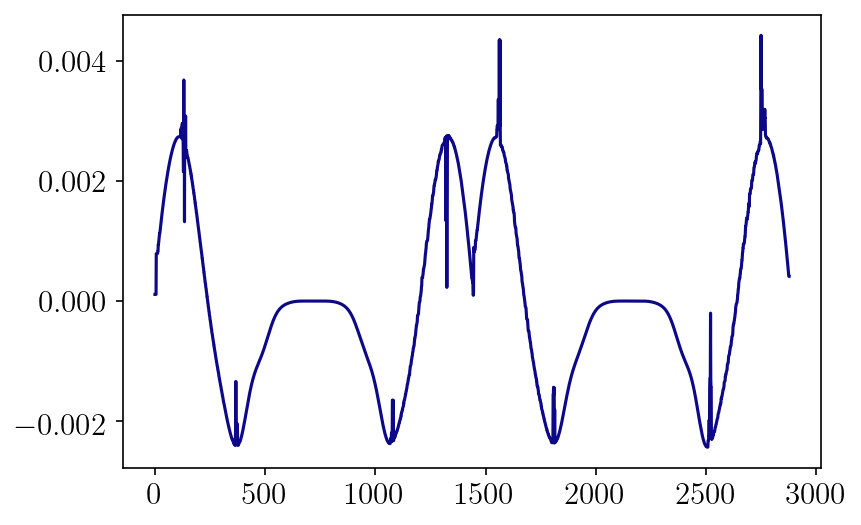

In [480]:
for i in range(1):
    updated_f = update_f(f)
    updated_f = im.median_filter(updated_f, 10)
    
    plt.plot(updated_f)

In [481]:
f += updated_f

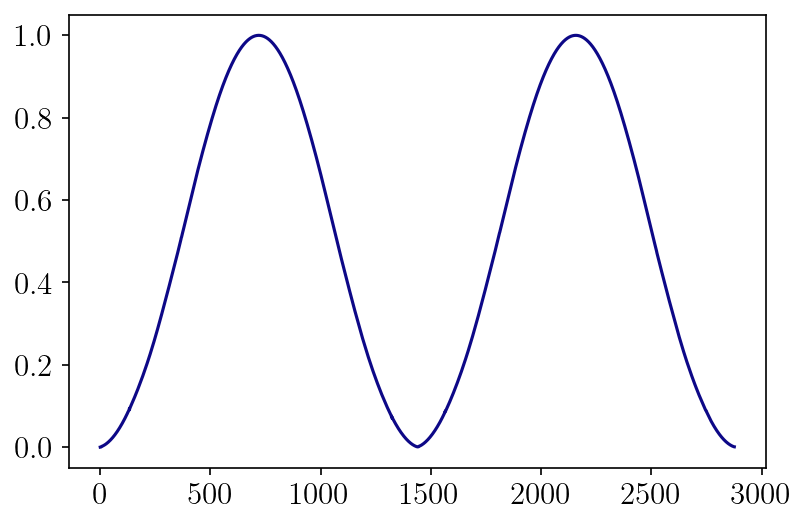

In [482]:
plt.plot(f)

In [201]:
from scipy.interpolate import InterpolatedUnivariateSpline

def diff_alpha(arr):
    a = np.linspace(0, 2 * (np.pi / 2), int(2 * steps))
    s = InterpolatedUnivariateSpline(alpha_eqs, arr, k=5)
    y = s(a)

    diff_arr = np.diff(y) / dalpha
    return diff_arr[0:steps]

def diff2_alpha(arr):
    a = np.linspace(0, 2 * (np.pi / 2), int(2 * steps))
    s = InterpolatedUnivariateSpline(alpha_eqs, arr, k=5)
    y = s(a)
    
    diff_arr = np.diff(y, n=2) / dalpha**2
    return diff_arr[0:steps]

In [210]:
def update_f(f):
    return (1 / (T_B_wrap * np.sin(2 * alpha_eqs))) * (diff_alpha(T_B * np.sin(2 * alpha_eqs) * D_a0a0) * diff_alpha(f) + (T_B * np.sin(2 * alpha_eqs) * D_a0a0) * diff2_alpha(f))

In [211]:
plt.plot(np.degrees(alpha_eqs), update_f(f))
plt.ylim([-1, 1])
plt.xlim([0, 90])

ValueError: operands could not be broadcast together with shapes (720,) (2880,) 

In [115]:

a = np.linspace(1e-5 - np.pi/4, (np.pi / 2) + np.pi/4, int(2 * steps))
s = InterpolatedUnivariateSpline(alpha_eqs, f, k=5)
y = s(a)

In [107]:
np.roll(test, -1) - 2 * test + np.roll(test, 1)

array([ 3,  0, -3])

In [15]:
N = 10

D = np.zeros((N, N + 2))
D2 = np.zeros((N, N + 2))

for i in range(N):
    D[i, i:i + 3] = np.array([-1, 0, 1])
    D2[i, i:i + 3] = np.array([1, -2, 1])


In [38]:
D_a0a0

NameError: name 'D_a0a0' is not defined

In [39]:
T_B

NameError: name 'T_B' is not defined

In [67]:
T_B = np.vectorize(lambda x: (4 * L_actual * Re / v) * T_alpha(x))
Daa = np.vectorize(lambda x: np.interp(x, alpha_eqs, D_a0a0))
f = lambda x: np.log(T_B(x) * np.sin(2 * x) * Daa(x))

In [68]:
def mat_for_eqn(lam, alpha_0):
    a11 = 0
    a12 = 1
    a21 = lam / Daa(alpha_0)
    
    dalpha = 1e-5
    a22 = -(f(alpha_0 + dalpha) - f(alpha_0)) / dalpha
    
    return np.array([[a11, a12], [a21, a22]])

In [108]:
h_0 = np.zeros(1000)
h_1 = np.zeros(1000)

alpha_list = np.linspace(eq_loss_cone_ang, np.radians(85), 1000)
dalpha = alpha_list[1] - alpha_list[0]

h_0[0] = 0

h_1[0] = 1 # This is a guess
lam = 1e-9 # This is a guess

for i in range(999):
    M = mat_for_eqn(lam, alpha_list[i])
    ic = np.array([[h_0[i]], [h_1[i]]])
    h_0[i + 1], h_1[i + 1] = ic + dalpha * np.matmul(M, ic)

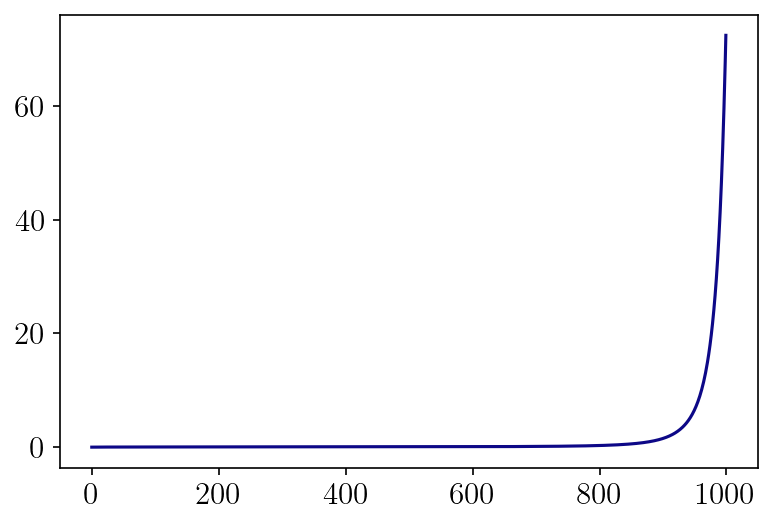

In [109]:
plt.plot(h_0)

In [16]:
E = 300e3
gamma = E / (sp.m_e * sp.c**2) + 1.
v = sp.c * np.sqrt(1. - 1. / gamma**2)

eps = epsilon_general(E, -sp.e, sp.m_e, flc(b_field, rr[cs_ind]), np.linalg.norm(b_field(rr[cs_ind])))
z1, z2 = zetas_general(b_field, L)

In [17]:
# eps = 0.37

# L = 5
# z1 = (2 / 3)
# z2 = 1

def T_dip(alpha):
    return 1.380173 - 0.639693 * np.sin(alpha)**0.75

def T_B(alpha):
    return (4 * L_actual * Re / v) * T_alpha(alpha)

def D_a0a0(alpha):
    return D_aa(eps, z1, z2, alpha, T_alpha)

T_B0 = T_B(0)

In [18]:
def diff_func(f, x):
    eps = 1e-2
    return (f(x + eps) - f(x)) / eps

def m22_func(alpha):
    return np.log((T_B(alpha) / T_B0) * np.sin(2 * alpha) * (T_B0 * D_a0a0(alpha)))

def fun(x, y, tau):
    
    M = np.array([
        [0, 1],
        [-1 / (tau * D_a0a0(x)), -diff_func(m22_func, x)]
    ])
    
    return np.matmul(M, y)

def bc(ya, yb):
    return (ya[0], yb[1])

In [214]:
def solve_h(x, y, tau):
    dx = x[1] - x[0]
    for i in range(len(x) - 1):   
        dy_dx = fun(x[i], y[:, i], tau)
        y[:, i + 1] = y[:, i] + dx * dy_dx
    return y

def solve_tau(tau_min, tau_max, alpha_max=85, iteration=0):
    if iteration > 20:
        print('Exceeded max iterations.')
        return None
    
    x = np.linspace(eq_loss_cone_ang, np.radians(alpha_max), 2000)
    y = np.zeros((2, x.size))
    
    dx = x[1] - x[0] 
    y[:, 0] = (0, 1)
    
    tau = tau_max
    y = solve_h(x, y, tau)
    end_bc_max = y[1, -2]
    
    tau = tau_min
    y = solve_h(x, y, tau)
    end_bc_min = y[1, -2]
    
    print(f'Tau Difference: {np.abs(tau_max - tau_min):.3e}, BC Difference: {np.abs(end_bc_max - end_bc_min):.3e}')
    
    if np.sign(end_bc_min * end_bc_max) == 1 and np.abs(end_bc_min - end_bc_max) > 1e-4:
        print('Change bounds of tau.')
        return tau_min, tau_max
    
    elif np.abs(tau_min - tau_max) <= 1e-4:
        return x, y, (tau_min + tau_max) * 0.5
    
    else:
        tau_mid = (tau_max + tau_min) * 0.5
        
        tau = tau_mid
        y = solve_h(x, y, tau)
        end_bc_mid = y[1, -2]
        
        if np.sign(end_bc_mid * end_bc_min) != 1:
            return solve_tau(tau_min, tau_mid, iteration + 1)
        elif np.sign(end_bc_mid * end_bc_max):
            return solve_tau(tau_mid, tau_max, iteration + 1)
        else:
            print('Not suppposed to happen.')
            return None
    
    return
    
 
solve_tau(10, 14, 85)

#plt.plot(x, y[0])

Tau Difference: 4.000e+00, BC Difference: 3.630e+02
Tau Difference: 2.000e+00, BC Difference: 5.351e-05
Tau Difference: 1.000e+00, BC Difference: 2.432e-05
Tau Difference: 5.000e-01, BC Difference: 1.163e-05
Tau Difference: 2.500e-01, BC Difference: 5.693e-06
Tau Difference: 1.250e-01, BC Difference: 2.816e-06
Tau Difference: 6.250e-02, BC Difference: 1.401e-06
Tau Difference: 3.125e-02, BC Difference: 6.986e-07
Tau Difference: 1.562e-02, BC Difference: 3.488e-07
Tau Difference: 7.812e-03, BC Difference: 1.743e-07
Tau Difference: 3.906e-03, BC Difference: 8.712e-08
Tau Difference: 1.953e-03, BC Difference: 4.355e-08
Tau Difference: 9.766e-04, BC Difference: 2.178e-08
Tau Difference: 4.883e-04, BC Difference: 1.089e-08
Tau Difference: 2.441e-04, BC Difference: 5.444e-09
Tau Difference: 1.221e-04, BC Difference: 2.722e-09
Tau Difference: 6.104e-05, BC Difference: 1.361e-09


(array([0.01300087, 0.0130031 , 0.01300533, ..., 0.01744884, 0.01745107,
        0.01745329]),
 array([[0.00000000e+00, 2.22732336e-06, 4.45436419e-06, ...,
         3.96542163e-03, 3.96719938e-03, 3.96897696e-03],
        [1.00000000e+00, 9.99873153e-01, 9.99746339e-01, ...,
         7.98158873e-01, 7.98078279e-01, 7.97997702e-01]]),
 11.999969482421875)

In [191]:
np.degrees(eq_loss_cone_ang)

0.7448951601644209

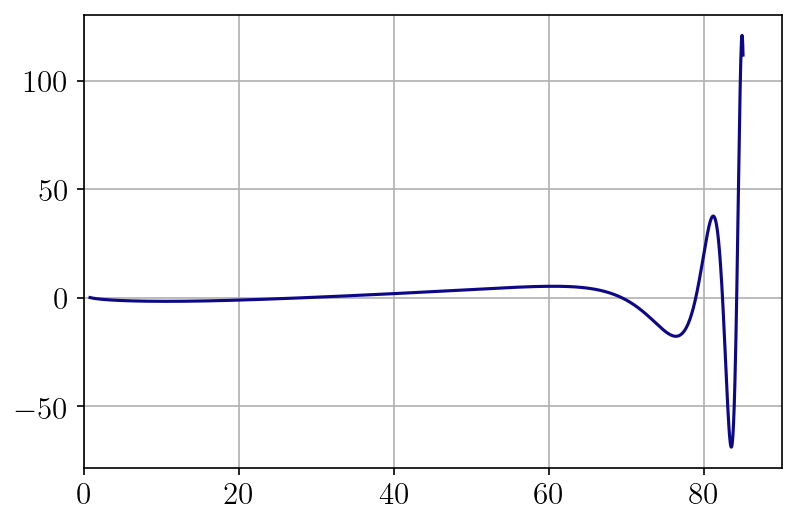

In [212]:
x = np.linspace(eq_loss_cone_ang, np.radians(85), 2000)
y = np.zeros((2, x.size))

dx = x[1] - x[0] 
y[:, 0] = (0, 1)

tau = # 11.999969482421875 # 16.999954223632812 # 29.999961853027344 # 49.999961853027344 # 154.99996185302734

y = solve_h(x, y, tau)
y[0] /= np.sum(y[0]) * dx

plt.plot(np.degrees(x), y[0])
plt.xlim([0, 90])
plt.grid()
plt.show()

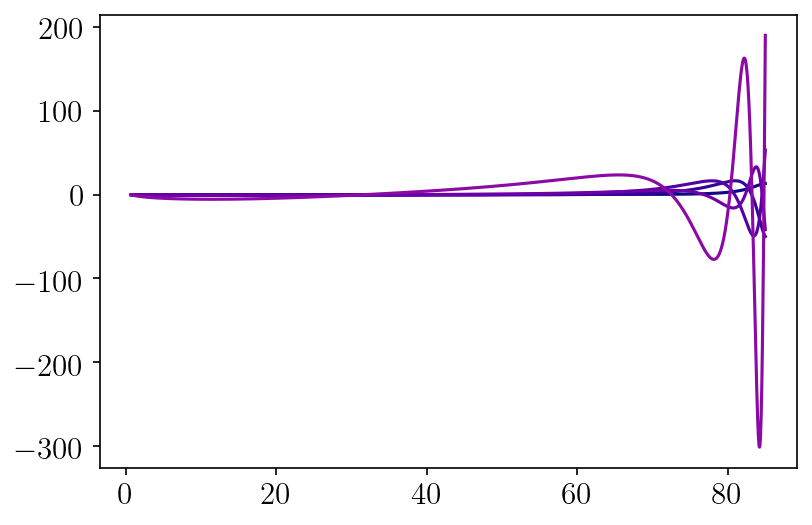

In [215]:
tau_list = [11.999969482421875, 16.999954223632812, 29.999961853027344, 49.999961853027344, 154.99996185302734]
tau_list = np.flip(tau_list)
ys = np.zeros((5, x.size))

for i, tau in enumerate(tau_list):
    y = solve_h(x, y, tau)
    y[0] /= np.sum(y[0]) * dx
    
    ys[i] = y[0]

    plt.plot(np.degrees(x), y[0])
    
plt.show()

In [216]:
for i in range(5):
    ys[i] /= np.sqrt(np.sum(ys[i] * ys[i]) * dx)

In [217]:
am = np.zeros(5)

for i in range(5):
    am[i] = np.sum(ys[i]) * dx

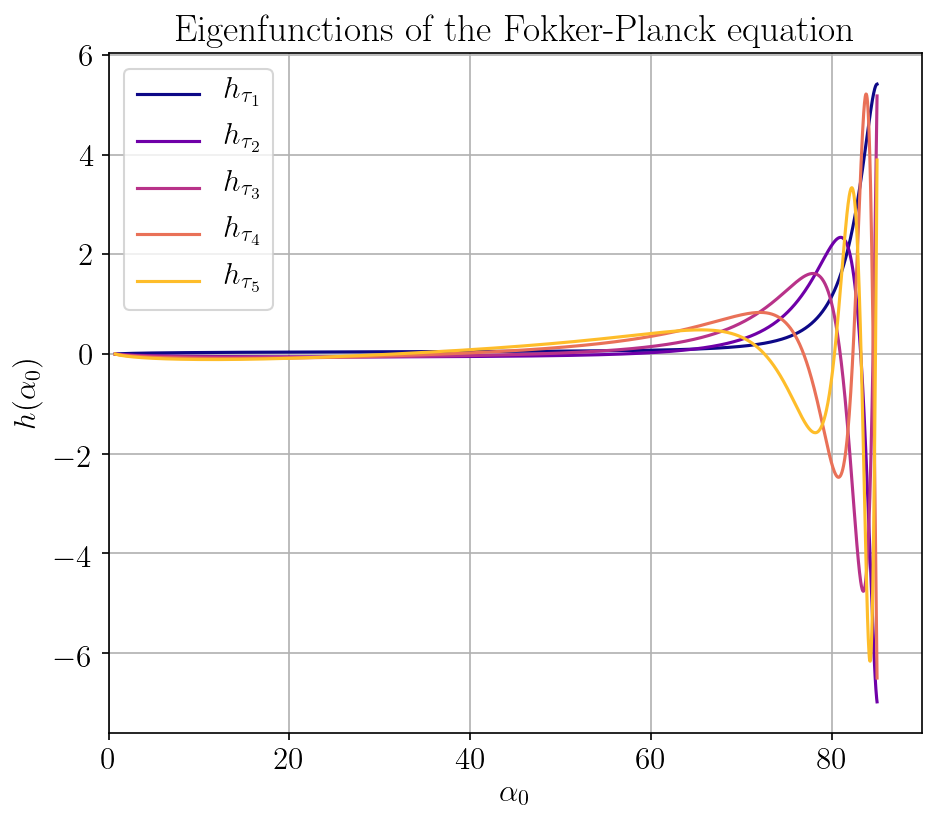

In [232]:
format_plots()

plt.figure(figsize=(7, 6))

for i in range(5):
    plt.plot(np.degrees(x), ys[i], c=f'C{3*i}', label=f'$h_{{\\tau_{i + 1}}}$')

plt.xlim([0, 90])
plt.xlabel('$\\alpha_0$')
plt.ylabel('$h(\\alpha_0)$')
plt.title('Eigenfunctions of the Fokker-Planck equation')
    
plt.legend()
plt.grid()
plt.show()

In [162]:
def y_test(t, weight):
    sn = np.zeros(x.size)
    for i in range(len(tau_list)):
        sn += weight[i] * ys[i] * np.exp(-t / tau_list[i])
    return sn

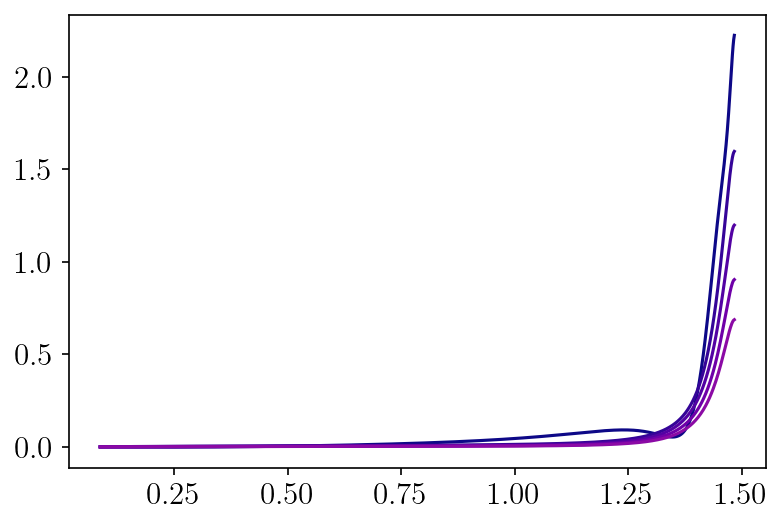

In [167]:
for i in np.arange(0, 200, 40):
    plt.plot(x, y_test(i, am))
plt.show()

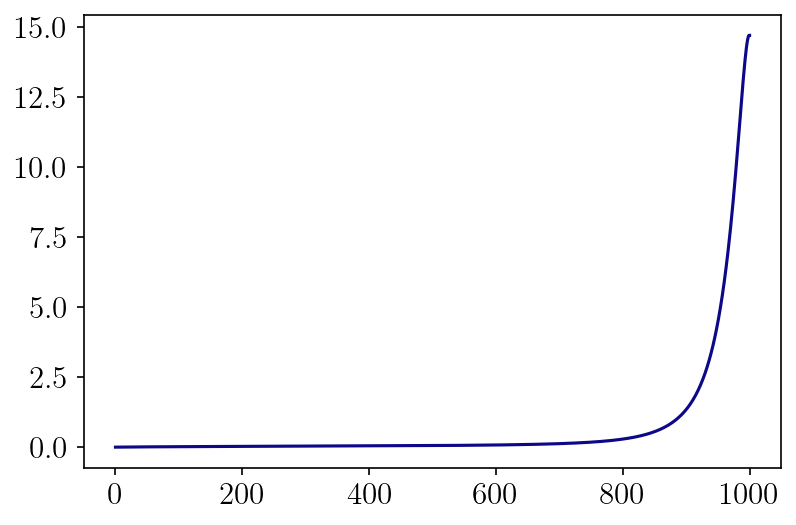

In [97]:
plt.plot(ys[3])